HaRe
====

HaRe (Harassment Recognizer) is a command line tool and Python library to automatically detect harassment as it happens (real-time) with the help of machine learning techniques. In this notebook we will look at the Python library.

Basic usage: monitoring conversations
--------------------------------------------------------

The easiest way to use HaRe is by simply loading a pretrained HaRe model included with this repo in the models folder, like the one named 'simple':

In [1]:
from hare import load_pretrained

moba_hare = load_pretrained('hare/pretrained/simple')

You can then use this object to monitor conversations in progress. Let's start a conversation and ask HaRe to monitor it:

In [2]:
from hare import Conversation

convo = Conversation()
moba_hare.add_conversation(convo)

At any point in time, you can then request the current status of the conversation according to this HaRe model:

In [3]:
convo.add_utterance(speaker='a',content='hello')
convo.add_utterance(speaker='b',content='hi everyone')
moba_hare.get_status()

{'a': 0.8264739513397217, 'b': 0.8264739513397217}

You can also add multiple sentences at once (for example a whole conversation if it has already finished), and see what HaRe's best guess was at every moment in time.

In [4]:
from hare import Utterance

convo.add_utterances([Utterance(speaker='a',content='good luck'),
                          Utterance(speaker='c',content='ur all n00bs')])

moba_hare.visualize_history_for_conversation()

a: hello
{'a': 0.8264739513397217}
---

b: hi everyone
{'a': 0.8264739513397217, 'b': 0.8264739513397217}
---

a: good luck
{'a': 0.8264739513397217, 'b': 0.8264739513397217}
---

c: ur all n00bs
{'a': 0.8264739513397217, 'b': 0.8264739513397217, 'c': 0.8264739513397217}
---



Or in a graph:

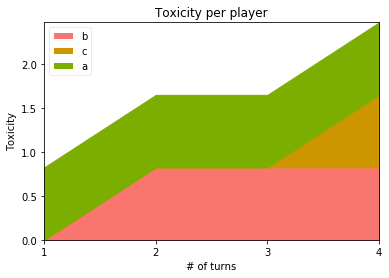

In [5]:
%matplotlib inline

from hare.visualize import visualize_toxicity_over_time
    
visualize_toxicity_over_time(moba_hare)

If you add multiple conversations for Hare to monitor, you will need to specify the conversation index when asking for the status:

In [6]:
second_convo = Conversation()

second_convo.add_utterance(speaker='a',content='hello')
second_convo.add_utterance(speaker='b',content='hi everyone')
second_convo.add_utterance(speaker='a',content='go away loser!')

moba_hare.add_conversation(second_convo)
moba_hare.get_status(id=1)

{'a': 0.8264739513397217, 'b': 0.8264739513397217}

Evaluating 
----------
If you have a labeled dataset (that is: for each conversation an indication which participants are considered toxic), HaRe can calculate to what extent its judgments match the labels. A label can range from the default 0 (not toxic at all) to 1 (maximally toxic). Let's label speaker c:

In [7]:
convo.label_speaker('c',1)
second_convo.label_speaker('a',0.9)

There are several evaluation metrics, depending on what is important to you (detecting ALL harassment, detecting harassment quickly, no false positives, etc):

In [8]:
for utterance_index in [0,1,2]:
    print('Accuracy of this HaRe at utterance',utterance_index,moba_hare.calculate_accuracy_at_utterance(utterance_index))
    
for utterance_index in [0,1,2]:
    print('AUC of this HaRe at utterance',utterance_index,moba_hare.calculate_auc_at_utterance(utterance_index))

[0, 0, 1, 1, 0] [1.0, 0.0, 0.0, 1.0, 0.0]
Accuracy of this HaRe at utterance 0 0.6
[0, 0, 1, 1, 0] [1.0, 1.0, 0.0, 1.0, 1.0]
Accuracy of this HaRe at utterance 1 0.2
[0, 0, 1, 1, 0] [1.0, 1.0, 0.0, 1.0, 1.0]
Accuracy of this HaRe at utterance 2 0.2
AUC of this HaRe at utterance 0 0.5833333333333334
AUC of this HaRe at utterance 1 0.25
AUC of this HaRe at utterance 2 0.25


Training
=======

If the existing pretrained models do not score high enough on your conversations, you can use train your own models. Before you cand do this, you need to select a 'brain', which is the classification algorithm HaRe will use under the hood. At the moment, neural networks with Bidirectional Gated Recurrent Units are popular for text classification, so we will use the `BiGruBrain`. This 'brain' uses the implementation in TensorFlow.

In [9]:
from hare import Hare, BiGruBrain

custom_hare = Hare()
custom_hare.brain = BiGruBrain()

An interesting option for BiGruBrains (and potentially others) is that they allow you to add word embeddings, which you can see as general knowledge on the meaning of words, collected from large amounts of texts (like Wikipedia).

In [10]:
custom_hare.brain.embedding_location = '/vol/bigdata/word_embeddings/glove/glove.6B.50d.txt'

Now, all we need to do is add the conversation we want to train on, and we're ready to start training.

In [11]:
custom_hare.add_conversation(convo)
custom_hare.add_conversation(second_convo)

custom_hare.train()
custom_hare.save('name_of_folder')

Epoch 1/3
5/5 [==============================] - 3s 520ms/step - loss: 0.7082 - acc: 0.2000
Epoch 2/3
5/5 [==============================] - 0s 9ms/step - loss: 0.6604 - acc: 0.6000
Epoch 3/3
5/5 [==============================] - 0s 9ms/step - loss: 0.6172 - acc: 0.6000
